In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from stable_baselines3 import DQN, DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
# from stable_baselines3.common.callbacks import EvalCallback

from alphaQ.utils import download_ticker_data, train_test_split, plot_episodes
from alphaQ.env import PortfolioEnv
from alphaQ.env2 import PortfolioEnvOld
from alphaQ.agent.features import FeatureExtractor
from alphaQ.agent.callbacks import EvalCallback
from alphaQ.agent.utils import AgentStrategy
from alphaQ.eval import evalu8, evaluate_baselines

import config
from config import TICKERS, MODEL, MODELS

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (18, 9)

In [3]:
# TICKERS = ['AXP', 'GE', 'INTC', 'NKE']

In [4]:
data = download_ticker_data(TICKERS, start=config.START, end=config.END, columns=['Open', 'High', 'Low', 'Close']).dropna()
train, val, test = train_test_split(data, train_years=10)

market = download_ticker_data('^DJI', start=config.START, end=config.END, columns=['Open', 'High', 'Low', 'Close']).loc[data.index]
market_train, market_val, market_test = train_test_split(market, train_years=10)

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
train.shape, val.shape, test.shape

((2520, 16), (423, 16), (423, 16))

In [6]:
market_train.shape, market_val.shape, market_test.shape

((2520, 4), (423, 4), (423, 4))

In [37]:
action_space_type = config.ACTION_SPACE[MODEL]

env = PortfolioEnv(
    tickers=TICKERS,
    prices=train, 
    market_prices=market_train,
    window_length=config.WINDOW_LENGTH,
    trading_cost=config.COMMISSION_RATE,
    action_space_type=action_space_type,
    render=True
)

val_env = PortfolioEnv(
    tickers=TICKERS,
    prices=val, 
    market_prices=market_val,
    window_length=config.WINDOW_LENGTH,
    trading_cost=config.COMMISSION_RATE,
    action_space_type=action_space_type,
)

### DQN

In [80]:
policy_kwargs = dict(
    features_extractor_class=FeatureExtractor,
    features_extractor_kwargs=dict(features_dim=(32+1)*4+1),
    net_arch=[256, 128, 64],
    # optimizer_kwargs=dict(weight_decay=5e-9)
)

In [81]:
agent = DQN(
    policy=config.POLICY, 
    env=env,
    learning_rate=config.ALPHA,
    learning_starts=config.TRAIN_START,
    batch_size=config.BATCH_SIZE, 
    buffer_size=config.BUFFER_SIZE, 
    tau=config.TAU,
    gamma=config.GAMMA,
    train_freq=config.TRAIN_FREQ,
    target_update_interval=config.TARGET_UPDATE,
    exploration_fraction=config.EPSILON_FRACTION,
    exploration_initial_eps=config.EPSILON_INITIAL,
    exploration_final_eps=config.EPSILON_FINAL,
    policy_kwargs=policy_kwargs,
    verbose=config.TRAIN_VERBOSE_LEVEL, 
    seed=config.RANDOM_SEED
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### DDPG

In [17]:
policy_kwargs = dict(
    features_extractor_class=FeatureExtractor,
    features_extractor_kwargs=dict(features_dim=(32+1)*4+1),
    net_arch=[512, 256, 128],
    # optimizer_kwargs=dict(weight_decay=5e-9)
)

In [19]:
if config.ACTION_NOISE:
    
    n_actions = env.action_space.shape[-1]

    action_noise = config.NOISE[config.ACTION_NOISE](
        mean=np.zeros(n_actions), 
        sigma=config.NOISE_SIGMA * np.ones(n_actions))

else:
    action_noise = None

In [11]:
agent = DDPG(
    policy=config.POLICY, 
    env=env,
    learning_rate=config.ALPHA,
    learning_starts=config.TRAIN_START,
    batch_size=config.BATCH_SIZE, 
    buffer_size=config.BUFFER_SIZE, 
    tau=config.TAU,
    gamma=config.GAMMA,
    train_freq=config.TRAIN_FREQ,
    action_noise=action_noise,
    policy_kwargs=policy_kwargs,
    verbose=config.TRAIN_VERBOSE_LEVEL, 
    seed=config.RANDOM_SEED
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### Train

In [84]:
episode_length = env.prices.shape[0] - config.WINDOW_LENGTH

if config.CALLBACK_ENABLED:
    eval_callback = EvalCallback(
        eval_env=val_env, 
        n_eval_episodes=1, 
        eval_freq=episode_length, 
        log_path=config.LOG_PATH, 
        best_model_save_path=config.SAVE_PATH, 
        verbose=config.CALLBACK_VERBOSE_LEVEL, 
        warn=False
    )
else:
    eval_callback = None

   Total wealth: 0.017510054990410612
Summary:
    Profit factor: 0.70
    Sharpe ratio: -1.70 ± 0.50
    Ulcer index: -0.47
    Information ratio (wrt UCRP): -4.77
    Appraisal ratio (wrt UCRP): -4.33 ± 0.32
    UCRP sharpe: 0.79 ± 0.37
    Beta / Alpha: 0.78 / -54.335%
    Annualized return: -33.77%
    Annualized volatility: 22.75%
    Longest drawdown: 2473 days
    Max drawdown: 98.27%
    Winning days: 42.8%
    Annual turnover: 224.9
        


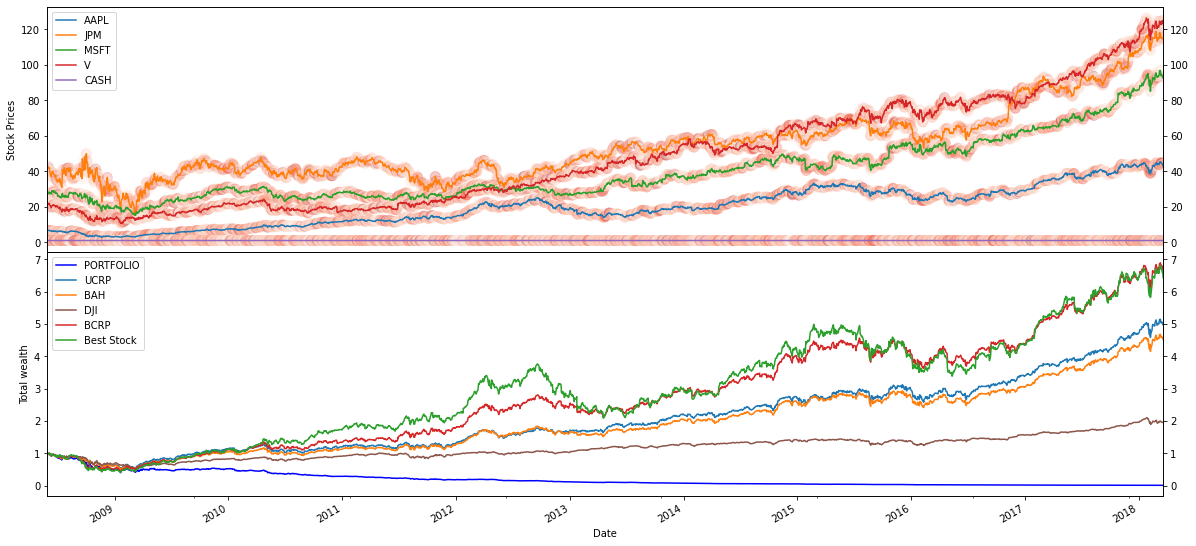

   Total wealth: 0.030508219665801844
Summary:
    Profit factor: 0.74
    Sharpe ratio: -1.39 ± 0.45
    Ulcer index: -0.44
    Information ratio (wrt UCRP): -4.42
    Appraisal ratio (wrt UCRP): -3.90 ± 0.32
    UCRP sharpe: 0.79 ± 0.37
    Beta / Alpha: 0.82 / -49.258%
    Annualized return: -29.92%
    Annualized volatility: 23.63%
    Longest drawdown: 2220 days
    Max drawdown: 97.21%
    Winning days: 42.2%
    Annual turnover: 223.8
        


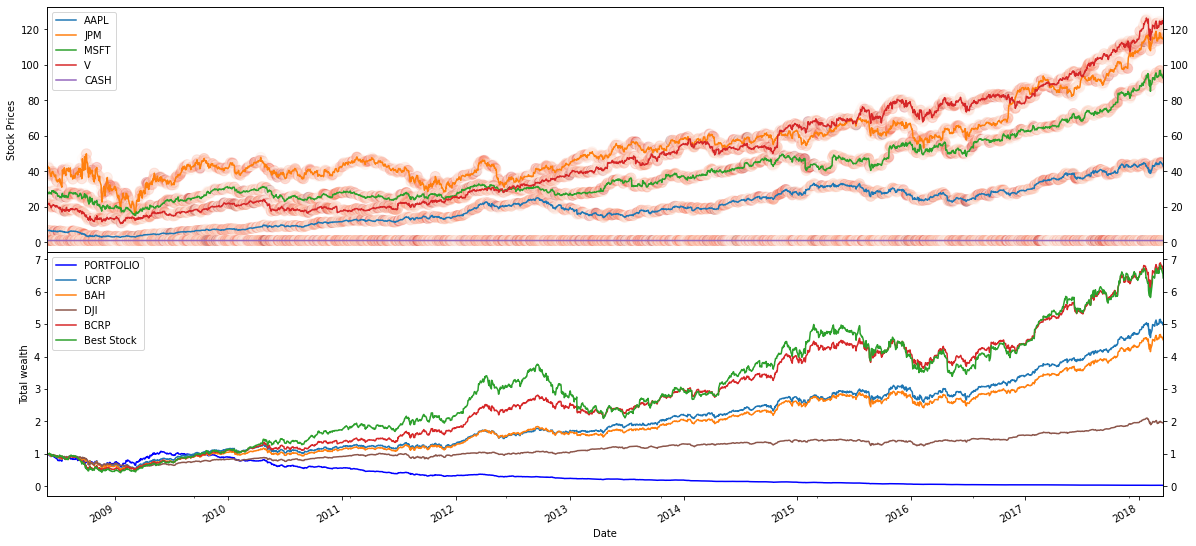

   Total wealth: 0.012164442466640233
Summary:
    Profit factor: 0.68
    Sharpe ratio: -1.84 ± 0.52
    Ulcer index: -0.48
    Information ratio (wrt UCRP): -5.07
    Appraisal ratio (wrt UCRP): -4.60 ± 0.32
    UCRP sharpe: 0.79 ± 0.37
    Beta / Alpha: 0.79 / -58.104%
    Annualized return: -36.18%
    Annualized volatility: 22.93%
    Longest drawdown: 2473 days
    Max drawdown: 98.78%
    Winning days: 42.2%
    Annual turnover: 223.7
        


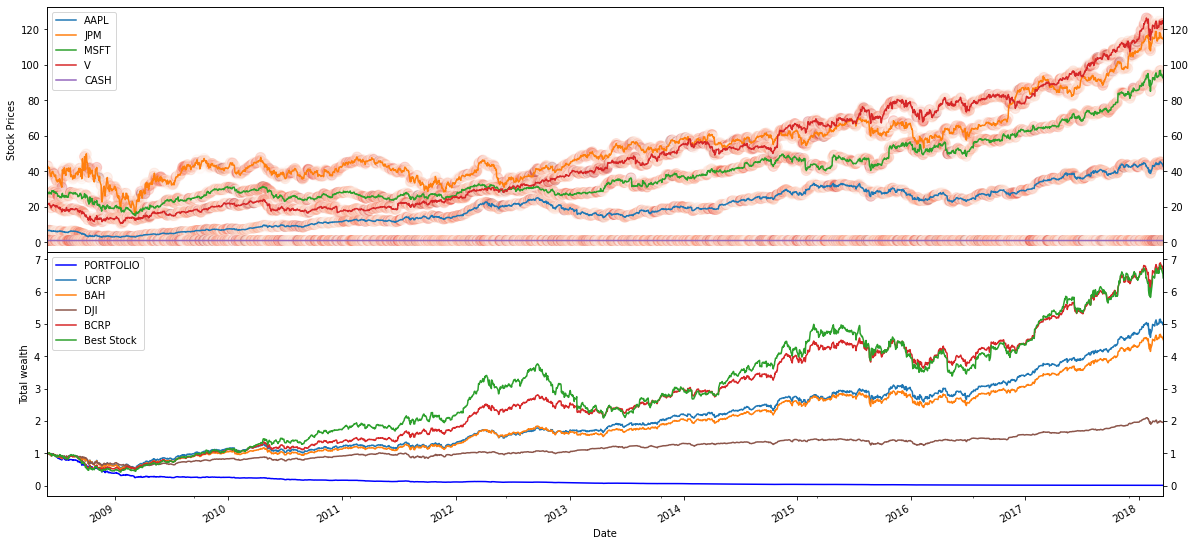

   Total wealth: 0.00966081984617919
Summary:
    Profit factor: 0.67
    Sharpe ratio: -1.91 ± 0.54
    Ulcer index: -0.52
    Information ratio (wrt UCRP): -5.32
    Appraisal ratio (wrt UCRP): -4.80 ± 0.32
    UCRP sharpe: 0.79 ± 0.37
    Beta / Alpha: 0.80 / -60.710%
    Annualized return: -37.66%
    Annualized volatility: 23.30%
    Longest drawdown: 2472 days
    Max drawdown: 99.05%
    Winning days: 41.5%
    Annual turnover: 223.6
        


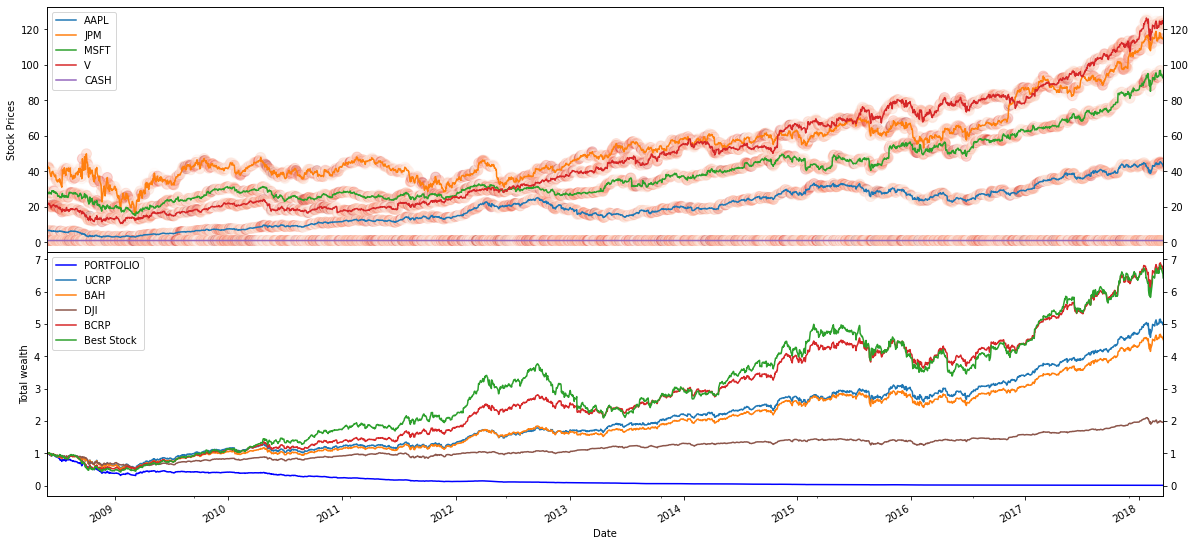

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.47e+03 |
|    ep_rew_mean      | -3.88    |
|    exploration rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 302      |
|    time_elapsed     | 32       |
|    total timesteps  | 9880     |
----------------------------------
   Total wealth: 0.9193486892485982
Summary:
    Profit factor: 0.99
    Sharpe ratio: 0.06 ± 0.32
    Ulcer index: 0.06
    Information ratio (wrt UCRP): -1.48
    Appraisal ratio (wrt UCRP): -1.09 ± 0.32
    UCRP sharpe: 0.79 ± 0.37
    Beta / Alpha: 0.71 / -12.962%
    Annualized return: -0.85%
    Annualized volatility: 20.83%
    Longest drawdown: 2472 days
    Max drawdown: 49.44%
    Winning days: 52.0%
    Annual turnover: 62.0
        


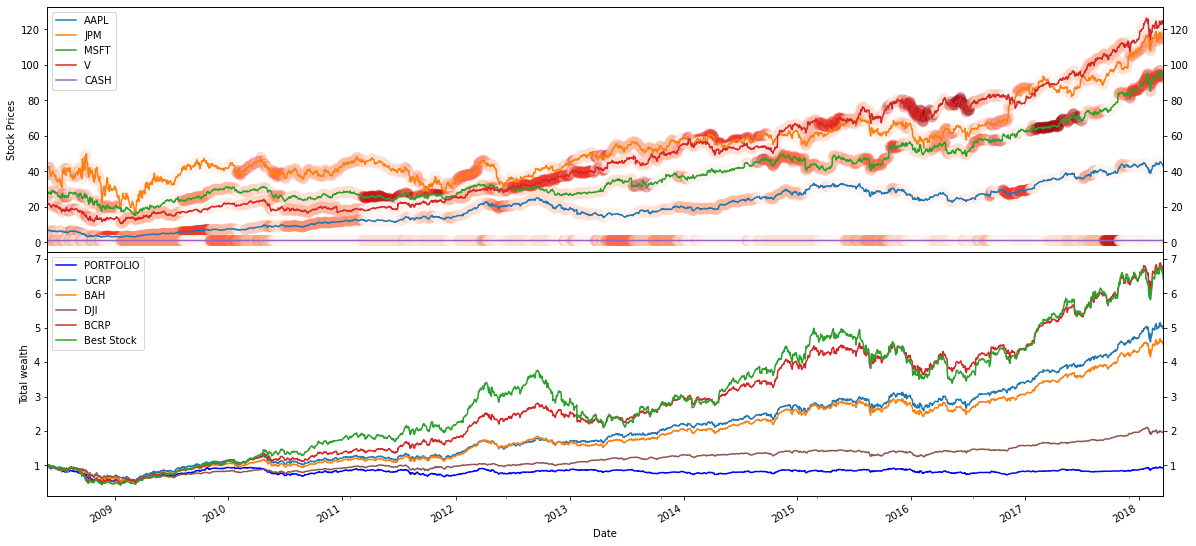

   Total wealth: 0.1956994651596343
Summary:
    Profit factor: 0.87
    Sharpe ratio: -0.60 ± 0.35
    Ulcer index: -0.22
    Information ratio (wrt UCRP): -2.56
    Appraisal ratio (wrt UCRP): -2.17 ± 0.32
    UCRP sharpe: 0.79 ± 0.37
    Beta / Alpha: 0.78 / -29.557%
    Annualized return: -15.31%
    Annualized volatility: 23.16%
    Longest drawdown: 2473 days
    Max drawdown: 81.54%
    Winning days: 48.4%
    Annual turnover: 111.7
        


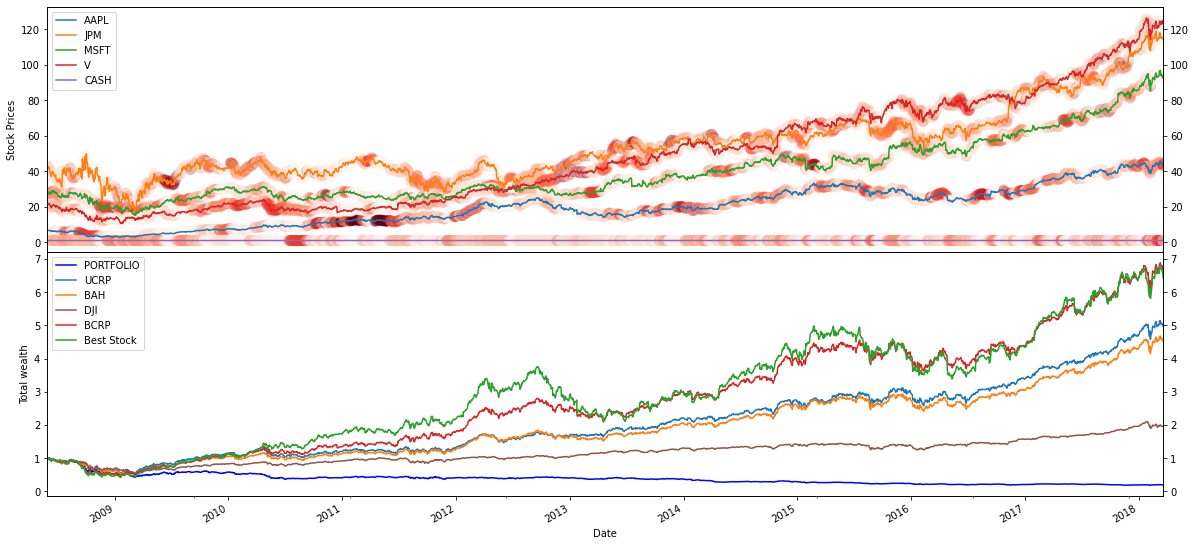

   Total wealth: 0.21617307807964597
Summary:
    Profit factor: 0.88
    Sharpe ratio: -0.55 ± 0.34
    Ulcer index: -0.26
    Information ratio (wrt UCRP): -2.79
    Appraisal ratio (wrt UCRP): -2.35 ± 0.32
    UCRP sharpe: 0.79 ± 0.37
    Beta / Alpha: 0.82 / -29.327%
    Annualized return: -14.45%
    Annualized volatility: 23.54%
    Longest drawdown: 2473 days
    Max drawdown: 79.08%
    Winning days: 48.7%
    Annual turnover: 137.6
        


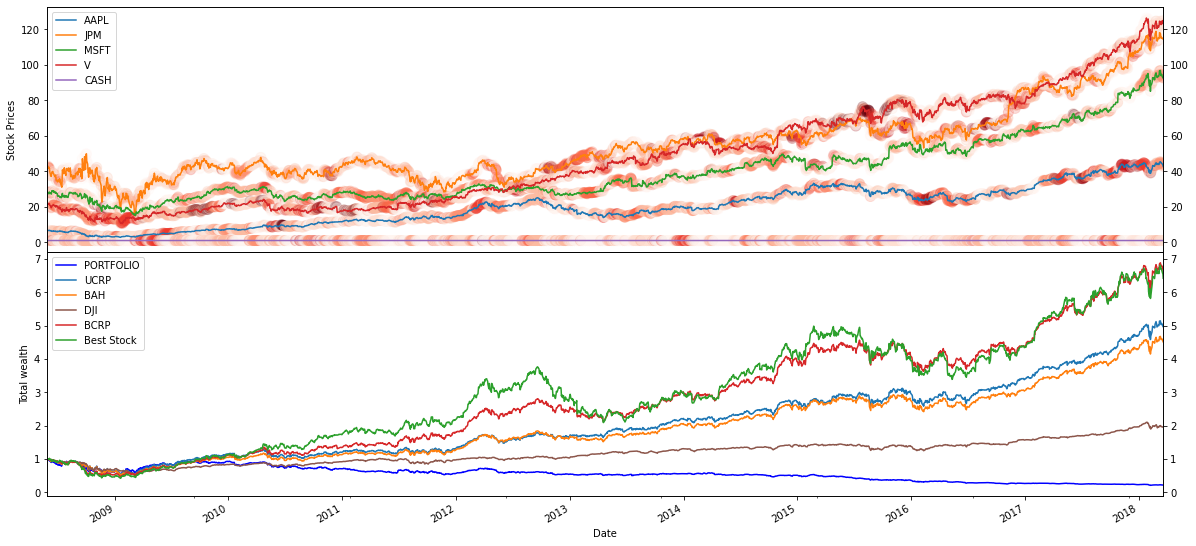

   Total wealth: 0.4240449204387537
Summary:
    Profit factor: 0.94
    Sharpe ratio: -0.18 ± 0.32
    Ulcer index: -0.09
    Information ratio (wrt UCRP): -1.72
    Appraisal ratio (wrt UCRP): -1.47 ± 0.32
    UCRP sharpe: 0.79 ± 0.37
    Beta / Alpha: 0.93 / -23.554%
    Annualized return: -8.37%
    Annualized volatility: 27.73%
    Longest drawdown: 2470 days
    Max drawdown: 67.66%
    Winning days: 48.6%
    Annual turnover: 124.0
        


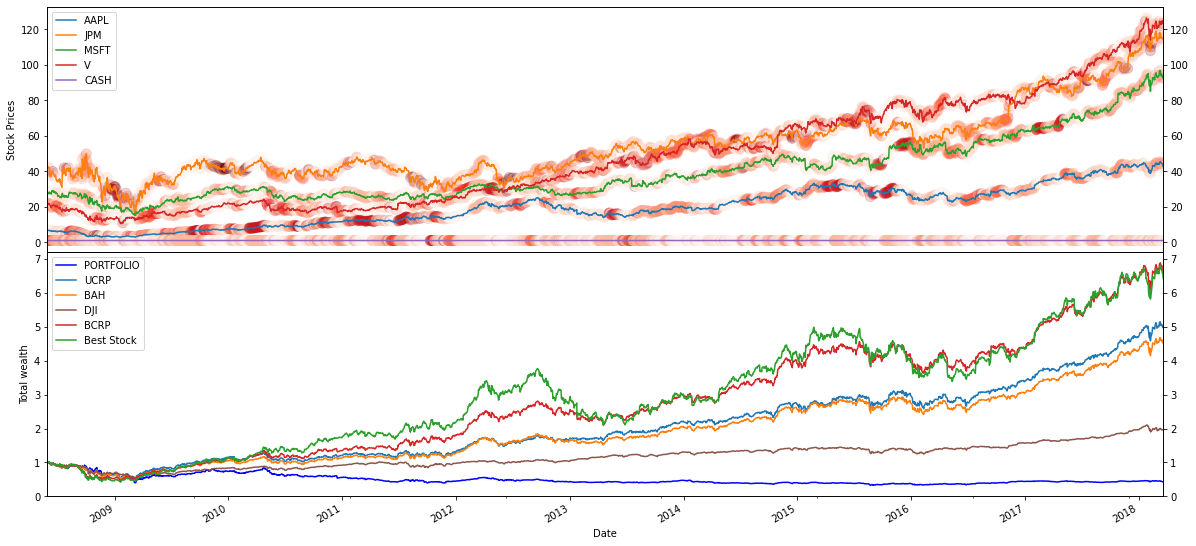

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.47e+03 |
|    ep_rew_mean      | -2.31    |
|    exploration rate | 0.01     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 100      |
|    time_elapsed     | 196      |
|    total timesteps  | 19760    |
| train/              |          |
|    learning_rate    | 2e-05    |
|    loss             | 6.46e-05 |
|    n_updates        | 9759     |
----------------------------------
   Total wealth: 0.424468907532439
Summary:
    Profit factor: 0.94
    Sharpe ratio: -0.14 ± 0.32
    Ulcer index: -0.07
    Information ratio (wrt UCRP): -1.69
    Appraisal ratio (wrt UCRP): -1.55 ± 0.32
    UCRP sharpe: 0.79 ± 0.37
    Beta / Alpha: 1.02 / -24.850%
    Annualized return: -8.36%
    Annualized volatility: 29.76%
    Longest drawdown: 2473 days
    Max drawdown: 74.20%
    Winning days: 50.9%
    Annual turnover: 94.5
        


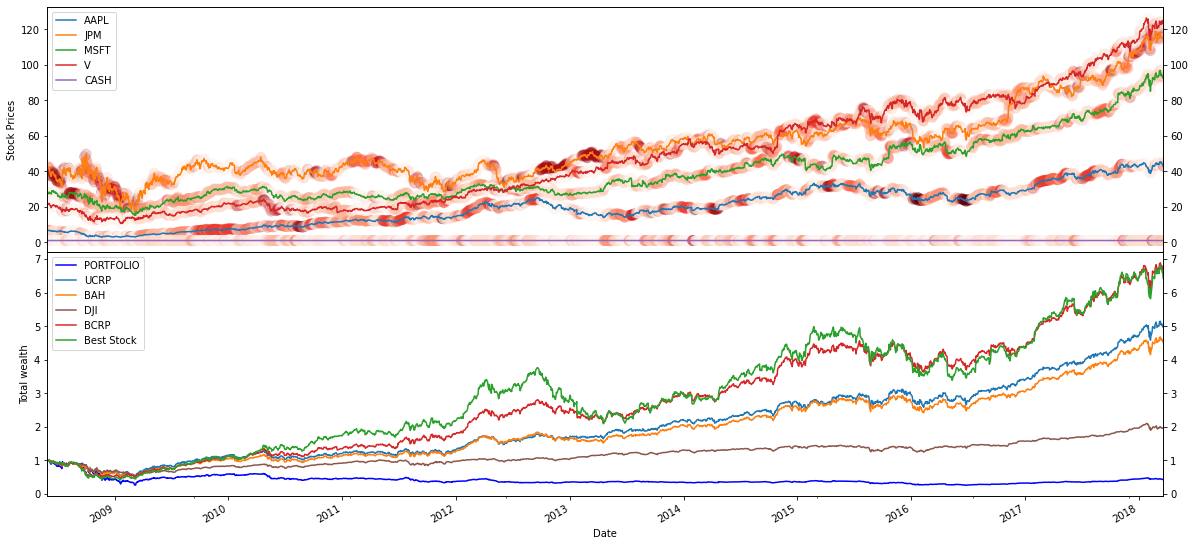

   Total wealth: 0.7461608679973036
Summary:
    Profit factor: 0.81
    Sharpe ratio: -1.12 ± 1.05
    Ulcer index: -0.80
    Information ratio (wrt UCRP): -4.09
    Appraisal ratio (wrt UCRP): -3.48 ± 0.83
    UCRP sharpe: 1.18 ± 1.07
    Beta / Alpha: 0.71 / -35.189%
    Annualized return: -17.99%
    Annualized volatility: 16.52%
    Longest drawdown: 327 days
    Max drawdown: 35.95%
    Winning days: 45.7%
    Annual turnover: 176.6
        


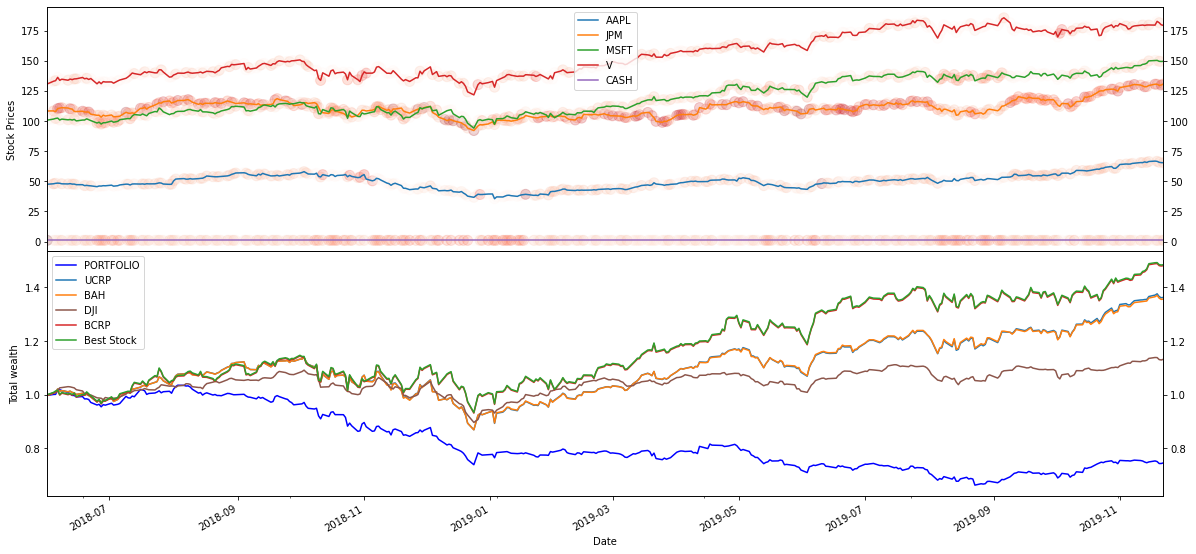

Eval num_timesteps=22230, episode_reward=-0.27 +/- 0.00
Episode length: 373.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 373      |
|    mean_reward      | -0.273   |
| rollout/            |          |
|    exploration rate | 0.01     |
| time/               |          |
|    total timesteps  | 22230    |
| train/              |          |
|    learning_rate    | 2e-05    |
|    loss             | 0.000134 |
|    n_updates        | 12229    |
----------------------------------
New best mean reward!
   Total wealth: 0.4060885864106805
Summary:
    Profit factor: 0.93
    Sharpe ratio: -0.22 ± 0.32
    Ulcer index: -0.12
    Information ratio (wrt UCRP): -2.04
    Appraisal ratio (wrt UCRP): -1.71 ± 0.32
    UCRP sharpe: 0.79 ± 0.37
    Beta / Alpha: 0.90 / -23.977%
    Annualized return: -8.77%
    Annualized volatility: 26.23%
    Longest drawdown: 1993 days
    Max drawdown: 70.89%
    Winning days: 49.0%
    Annual turnover

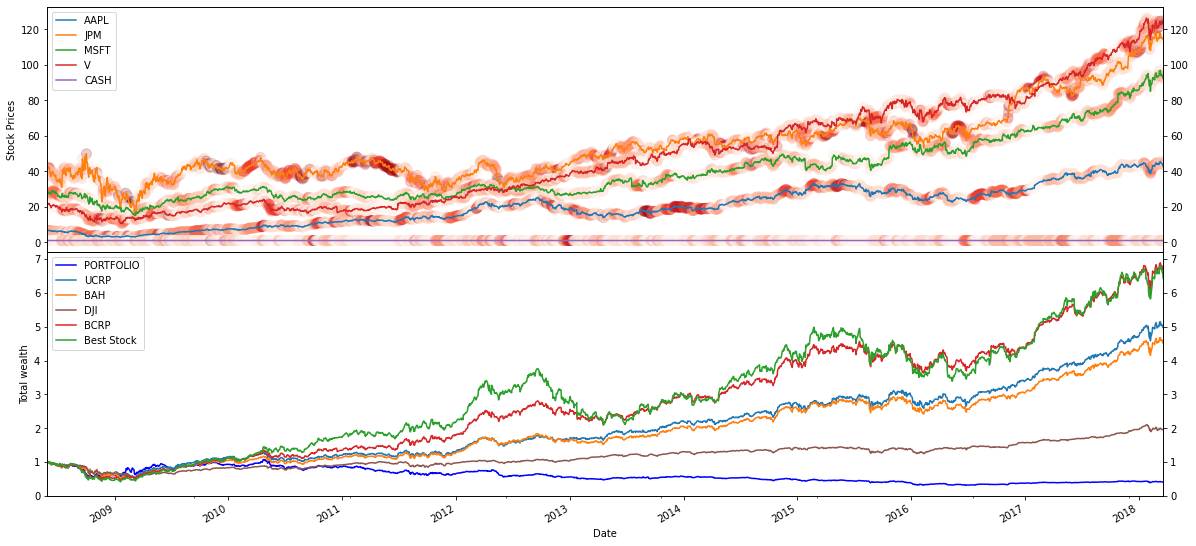

   Total wealth: 0.5361925358690166
Summary:
    Profit factor: 0.68
    Sharpe ratio: -1.99 ± 1.42
    Ulcer index: -1.27
    Information ratio (wrt UCRP): -8.01
    Appraisal ratio (wrt UCRP): -6.58 ± 0.83
    UCRP sharpe: 1.18 ± 1.07
    Beta / Alpha: 0.94 / -62.129%
    Annualized return: -34.43%
    Annualized volatility: 20.21%
    Longest drawdown: 368 days
    Max drawdown: 47.22%
    Winning days: 45.7%
    Annual turnover: 238.0
        


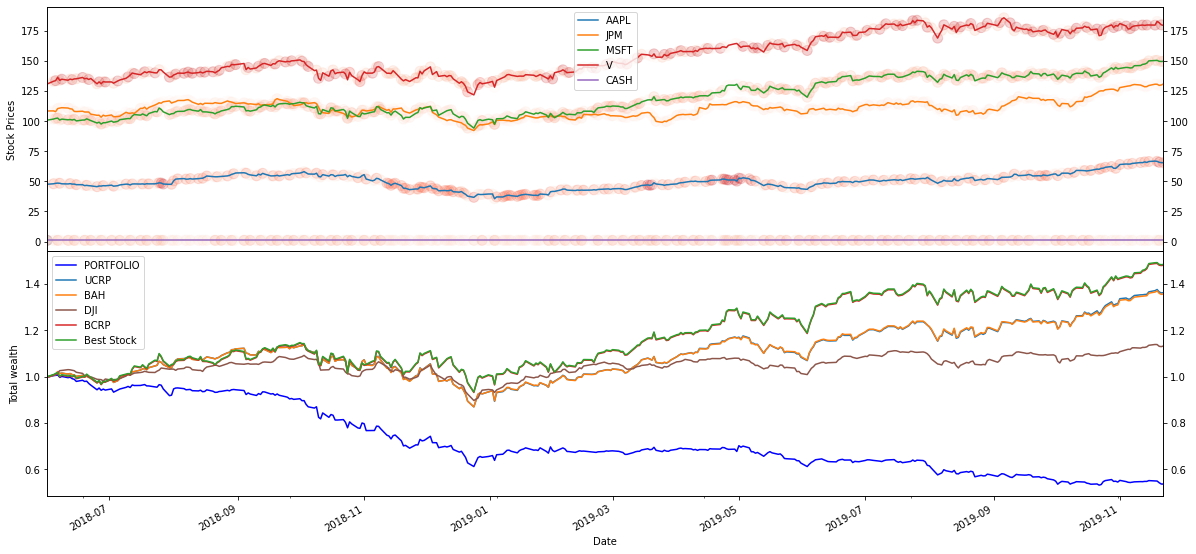

Eval num_timesteps=24700, episode_reward=-0.59 +/- 0.00
Episode length: 373.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 373      |
|    mean_reward      | -0.593   |
| rollout/            |          |
|    exploration rate | 0.01     |
| time/               |          |
|    total timesteps  | 24700    |
| train/              |          |
|    learning_rate    | 2e-05    |
|    loss             | 0.000119 |
|    n_updates        | 14699    |
----------------------------------


In [85]:
agent.learn(total_timesteps=10*episode_length, callback=eval_callback)

mean:
rewards        -2.109556
total_wealth    0.243267
dtype: float64


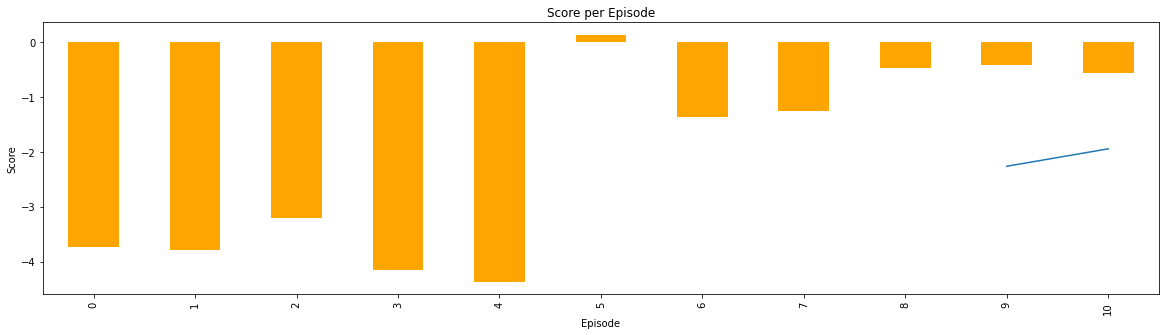

   Total wealth: 0.4060885864106805
Summary:
    Profit factor: 0.93
    Sharpe ratio: -0.22 ± 0.32
    Ulcer index: -0.12
    Information ratio (wrt UCRP): -2.04
    Appraisal ratio (wrt UCRP): -1.71 ± 0.32
    UCRP sharpe: 0.79 ± 0.37
    Beta / Alpha: 0.90 / -23.977%
    Annualized return: -8.77%
    Annualized volatility: 26.23%
    Longest drawdown: 1993 days
    Max drawdown: 70.89%
    Winning days: 49.0%
    Annual turnover: 102.5
        


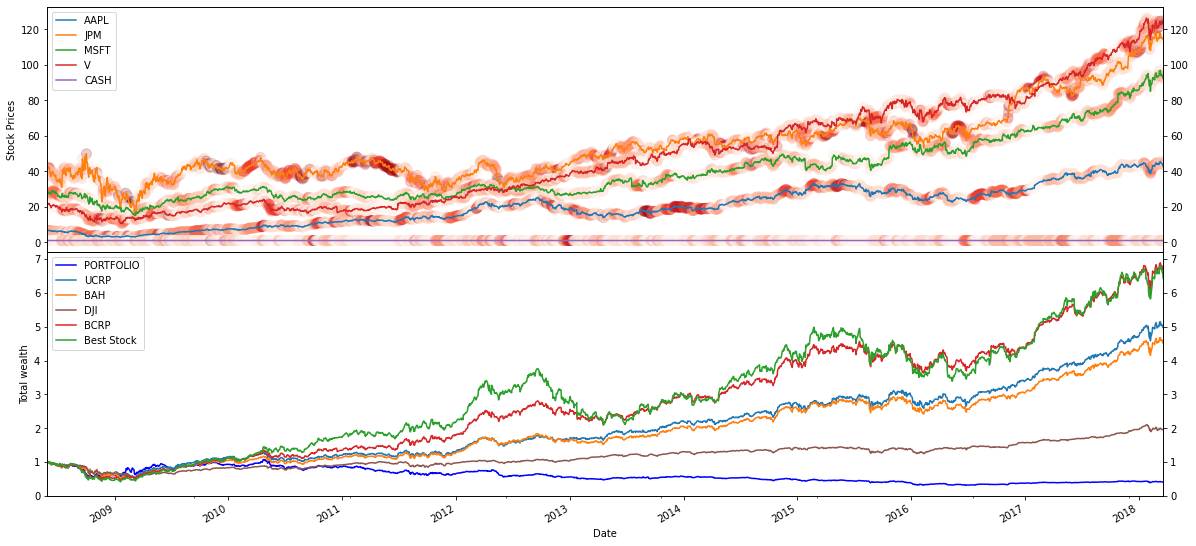

In [115]:
plot_episodes(env)

mean:
rewards        -0.432515
total_wealth    0.641378
dtype: float64


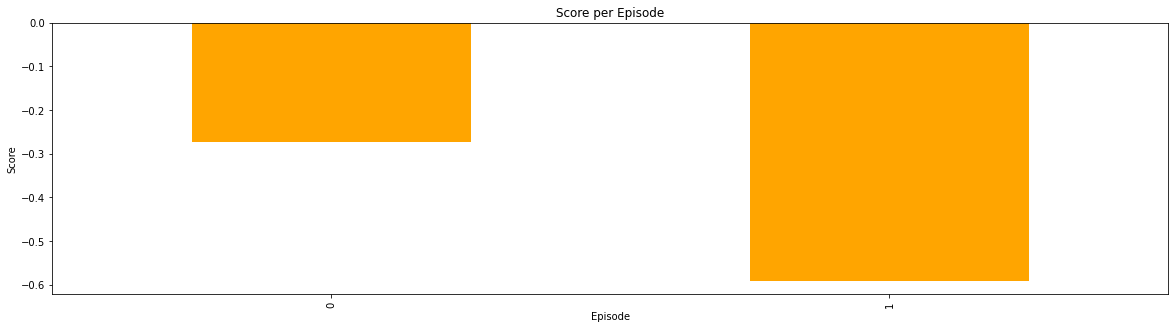

   Total wealth: 0.5361925358690166
Summary:
    Profit factor: 0.68
    Sharpe ratio: -1.99 ± 1.42
    Ulcer index: -1.27
    Information ratio (wrt UCRP): -8.01
    Appraisal ratio (wrt UCRP): -6.58 ± 0.83
    UCRP sharpe: 1.18 ± 1.07
    Beta / Alpha: 0.94 / -62.129%
    Annualized return: -34.43%
    Annualized volatility: 20.21%
    Longest drawdown: 368 days
    Max drawdown: 47.22%
    Winning days: 45.7%
    Annual turnover: 238.0
        


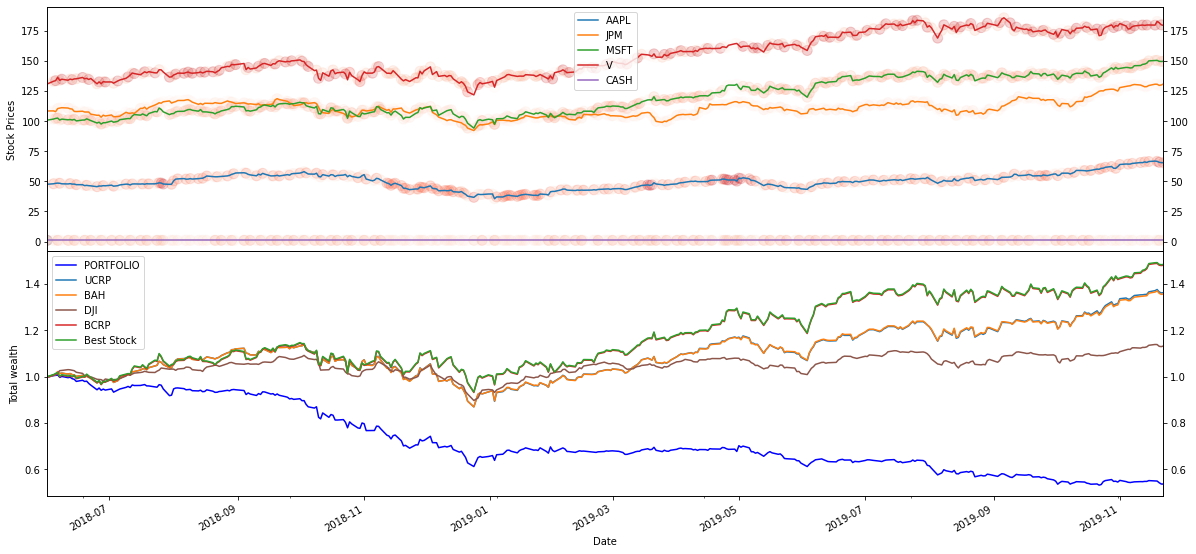

In [114]:
plot_episodes(val_env)

### Test

In [9]:
# del agent

In [77]:
agents = []

'''Choose only one of the following options.'''

# # single agent from path
# if 'agent' not in locals():
#     print(f'Loading {MODEL} model...')
#     agents.append(MODELS[MODEL].load(config.MODEL_PATH[MODEL]))

# all agents in saved paths
for model, path in config.MODEL_PATH.items():
    agents.append((model, MODELS[model].load(path)))

# # all agents in some directory
# PATH = 'models/'
# for file in os.listdir(PATH):
#     if file.startswith('DDPG'):
#         m = DDPG
#         model = 'ddpg'  
#     elif file.startswith('DQN'):
#         m = DQN
#         model = 'dqn'
#     print(file)
#     agents.append((model, m.load(PATH+file)))

(4, 4, 50)
(4, 4, 50)
(4, 4, 50)
(4, 4, 50)


   Total wealth: 1.552322666577497
Summary:
    Profit factor: 1.16
    Sharpe ratio: 0.99 ± 1.00
    Ulcer index: 4.26
    Information ratio (wrt UCRP): 0.41
    Appraisal ratio (CAPM): -0.97 ± 0.83
    Appraisal ratio (wrt UCRP): 0.48 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.97 / 6.988%
    Annualized return: 36.56%
    Annualized volatility: 36.91%
    Longest drawdown: 98 days
    Max drawdown: 30.40%
    Winning days: 54.0%
    Annual turnover: 12.7
        


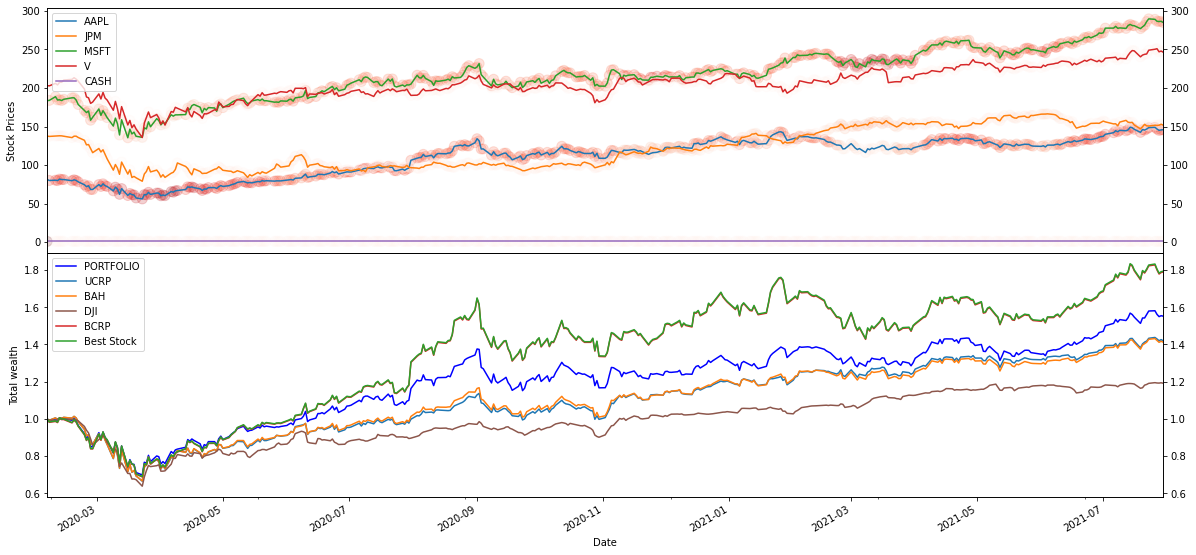

   Total wealth: 1.5253222094678653
Summary:
    Profit factor: 1.19
    Sharpe ratio: 1.02 ± 1.01
    Ulcer index: 3.62
    Information ratio (wrt UCRP): 0.28
    Appraisal ratio (CAPM): 0.36 ± 0.83
    Appraisal ratio (wrt UCRP): 0.57 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.89 / 7.010%
    Annualized return: 34.14%
    Annualized volatility: 33.54%
    Longest drawdown: 130 days
    Max drawdown: 29.56%
    Winning days: 55.3%
    Annual turnover: 14.5
        


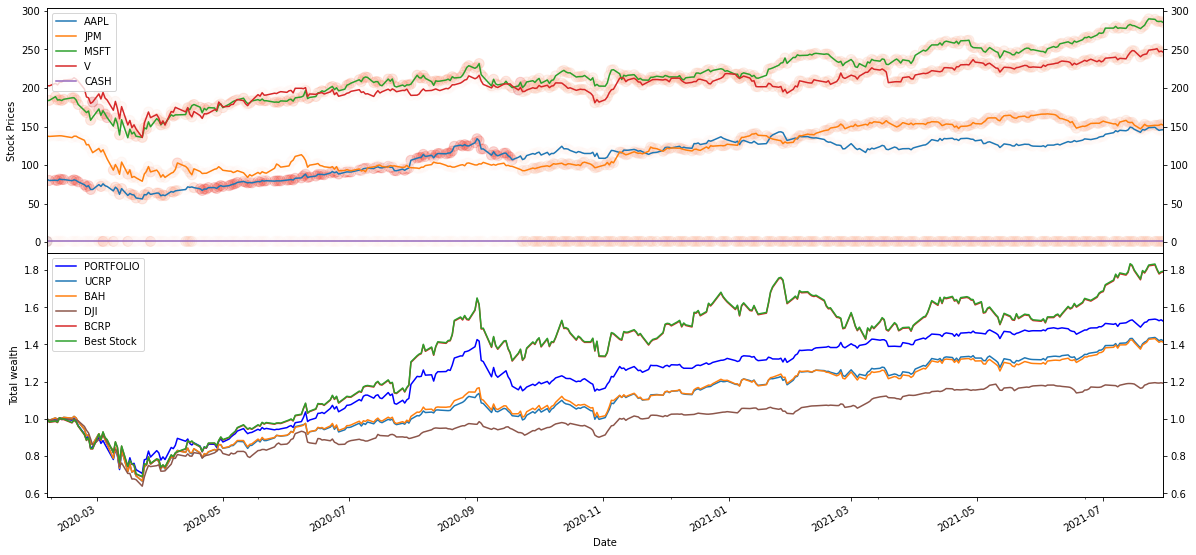

In [79]:
agent_strategies = []
palette = sns.color_palette(n_colors=len(TICKERS)+1)

for model, agent in agents:
    
    action_space_type = config.ACTION_SPACE[model]

    test_env = PortfolioEnv(
        tickers=TICKERS,
        prices=test, 
        market_prices=market_test,
        window_length=config.WINDOW_LENGTH,
        trading_cost=config.COMMISSION_RATE,
        action_space_type=action_space_type,
    )

    # test_env2 = PortfolioEnvOld(
    #     tickers=TICKERS,
    #     prices=test, 
    #     market_prices=market_test,
    #     window_length=config.WINDOW_LENGTH,
    #     trading_cost=config.COMMISSION_RATE,
    #     action_space_type=action_space_type,
    # )

#     print('lr:', agent.learning_rate, '\tgamma:', agent.gamma, '\tbatch_size:', agent.batch_size)
#     print(agent.policy_kwargs)
#     if 'features_extractor_class' in agent.policy_kwargs:
#         x = agent.policy_kwargs['features_extractor_class'](test_env.observation_space)
#         print(x.cnn)

#     try:
    evalu8(agent, test_env)
#     tenv = test_env
#     print('test1')
#     except:
#         evalu8(agent, test_env2)
#         tenv = test_env2
#         print('test2')

    strategy = AgentStrategy(test_env.record.actions, name=model.upper())
    agent_strategies.append(strategy)

In [80]:
results, metrics = evaluate_baselines(test, agent_strategies)

DDPG.DQN.BAH.CRP.BCRP.UP.EG.Anticor.PAMR.OLMAR.RMR.CWMR.WMAMR.CORN.ONS.

In [66]:
metrics.sort_values('sharpe', ascending=False)

total_wealth profit_factor    sharpe annualized_return max_drawdown  \
BCRP        1.789556       1.18855  1.158635         47.886554    31.427266   
DQN         1.525322      1.192137  1.017808         34.141995    29.561732   
DDPG        1.552323       1.16497  0.990563         36.563383    30.403945   
CRP         1.419826      1.146566  0.852642         29.827194    34.332293   
EG          1.419373      1.146346  0.852032         29.805738    34.327305   
UP          1.418484      1.145833  0.850814         29.764328    34.295793   
ONS         1.429529      1.147327  0.847373         30.720743    34.631883   
BAH         1.411977      1.141778  0.839949         29.506246    34.231834   
Anticor     1.418631      1.120933  0.808704         30.965307    34.332293   
RMR         1.212772      1.061545   0.52466         21.109587    34.332293   
OLMAR       1.183073       1.05311  0.482841         19.459773    34.332293   
WMAMR       1.038245      1.010442  0.286478         13.326967    41.118134   
CORN        0.533001      0.812629 -0.900839        -34.974396    48.488216   
CWMR        0.448385      0.771513 -1.100518        -45.577128    55.049169   
PAMR        0.445866      0.769621 -1.110501        -45.966234     55.30161   

        drawdown_period information winning_pct annual_turnover  
BCRP         110.650355    0.792765   52.815013             0.0  
DQN          129.590506    0.275839   55.347594       14.470241  
DDPG          97.691305    0.414969   54.010695       12.657078  
CRP          113.640905   -3.799032   54.278075        2.437476  
EG           113.640905   -3.072897   54.545455        2.313056  
UP           113.640905   -1.242656   54.545455        1.948611  
ONS          129.590506    0.011915   52.673797        8.750662  
BAH          113.640905   -0.353845   55.080214             0.0  
Anticor      103.672405    0.021648   52.673797       34.743598  
RMR          144.543257   -0.511768   51.871658       57.337781  
OLMAR        110.650355   -0.615833   50.802139       56.793544  
WMAMR        258.184162   -0.735712   51.336898       78.762103  
CORN         363.850267   -3.428915   41.666667      275.392238  
CWMR         371.825068    -3.67393   44.919786      354.091779  
PAMR         371.825068   -3.692322   44.652406      355.147766

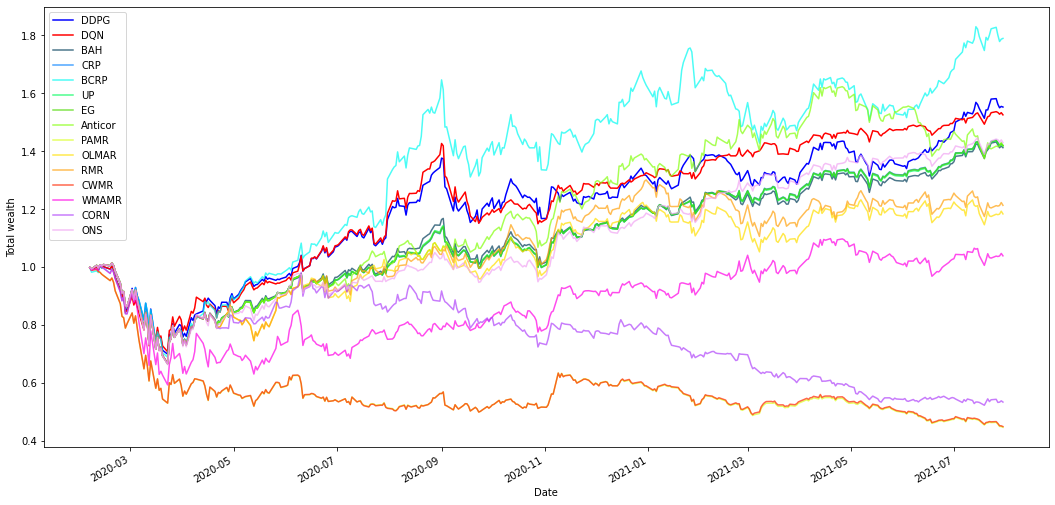

In [94]:
palette = sns.color_palette(palette='gist_ncar', n_colors=len(config.OLPS_STRATEGIES))

fig, ax = plt.subplots()

for name, result, color in zip(results.index, results, ['blue', 'red'] + palette):
    if name in ['DDPG', 'DQN']:
        alpha = 1
    else:
        alpha = 0.7
    result.plot(assets=False, weights=False, ucrp=False, bah=False, 
                portfolio_label=name, color=color, ax=ax, alpha=alpha)

#### Individual Plots

DDPG Summary:
    Profit factor: 1.16
    Sharpe ratio: 0.99 ± 1.00
    Ulcer index: 4.26
    Information ratio (wrt UCRP): 0.41
    Appraisal ratio (CAPM): -0.97 ± 0.83
    Appraisal ratio (wrt UCRP): 0.48 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.97 / 6.988%
    Annualized return: 36.56%
    Annualized volatility: 36.91%
    Longest drawdown: 98 days
    Max drawdown: 30.40%
    Winning days: 54.0%
    Annual turnover: 12.7
        


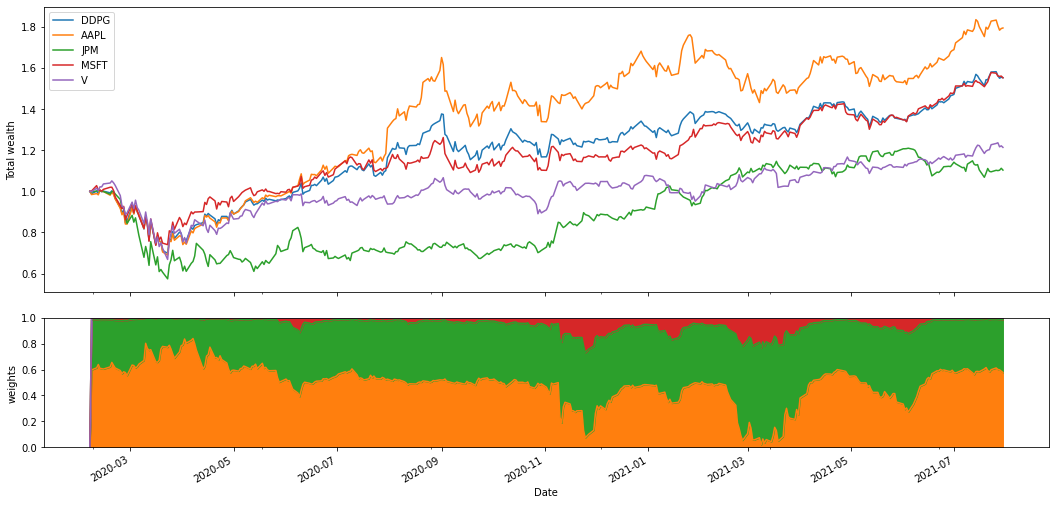

BAH Summary:
    Profit factor: 1.14
    Sharpe ratio: 0.84 ± 0.96
    Ulcer index: 3.26
    Information ratio (wrt UCRP): -0.35
    Appraisal ratio (CAPM): -2.47 ± 0.83
    Appraisal ratio (wrt UCRP): -0.29 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.00 / -0.940%
    Annualized return: 29.51%
    Annualized volatility: 35.13%
    Longest drawdown: 114 days
    Max drawdown: 34.23%
    Winning days: 55.1%
    Annual turnover: 0.0
        


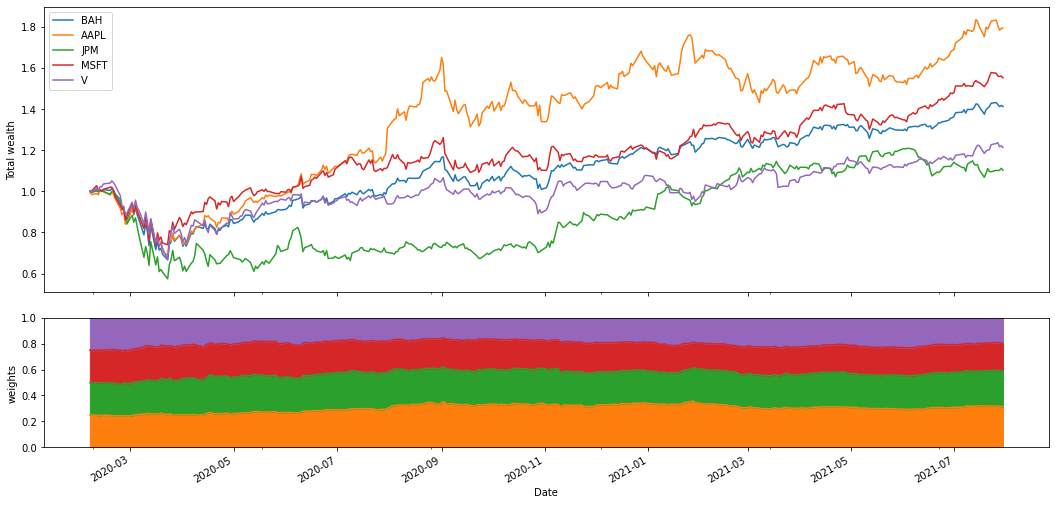

CRP Summary:
    Profit factor: 1.15
    Sharpe ratio: 0.85 ± 0.96
    Ulcer index: 3.32
    Information ratio (wrt UCRP): -3.80
    Appraisal ratio (CAPM): -4.83 ± 0.83
    Appraisal ratio (wrt UCRP): -4.82 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.00 / -0.610%
    Annualized return: 29.83%
    Annualized volatility: 34.98%
    Longest drawdown: 114 days
    Max drawdown: 34.33%
    Winning days: 54.3%
    Annual turnover: 2.4
        


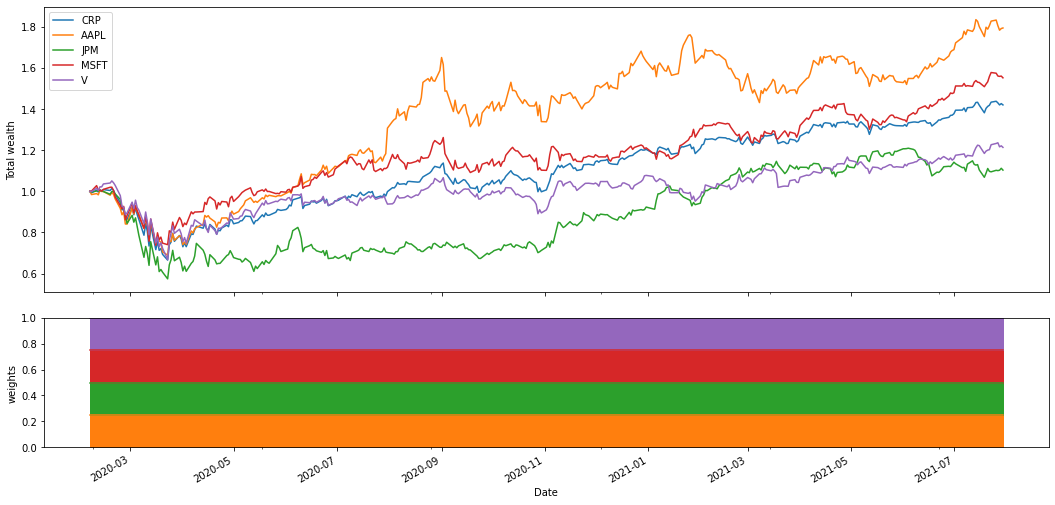

BCRP Summary:
    Profit factor: 1.19
    Sharpe ratio: 1.16 ± 1.06
    Ulcer index: 4.41
    Information ratio (wrt UCRP): 0.79
    Appraisal ratio (CAPM): 0.00 ± 1.05
    Appraisal ratio (wrt UCRP): 0.79 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.00 / 17.380%
    Annualized return: 47.89%
    Annualized volatility: 41.33%
    Longest drawdown: 111 days
    Max drawdown: 31.43%
    Winning days: 52.8%
    Annual turnover: 0.0
        


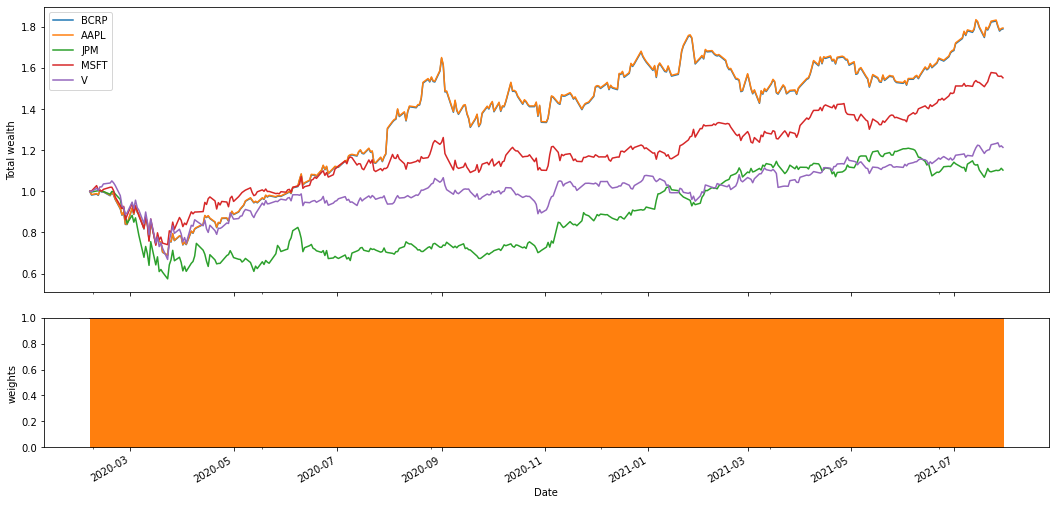

UP Summary:
    Profit factor: 1.15
    Sharpe ratio: 0.85 ± 0.96
    Ulcer index: 3.31
    Information ratio (wrt UCRP): -1.24
    Appraisal ratio (CAPM): -3.24 ± 0.83
    Appraisal ratio (wrt UCRP): -0.89 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.00 / -0.669%
    Annualized return: 29.76%
    Annualized volatility: 34.98%
    Longest drawdown: 114 days
    Max drawdown: 34.30%
    Winning days: 54.5%
    Annual turnover: 1.9
        


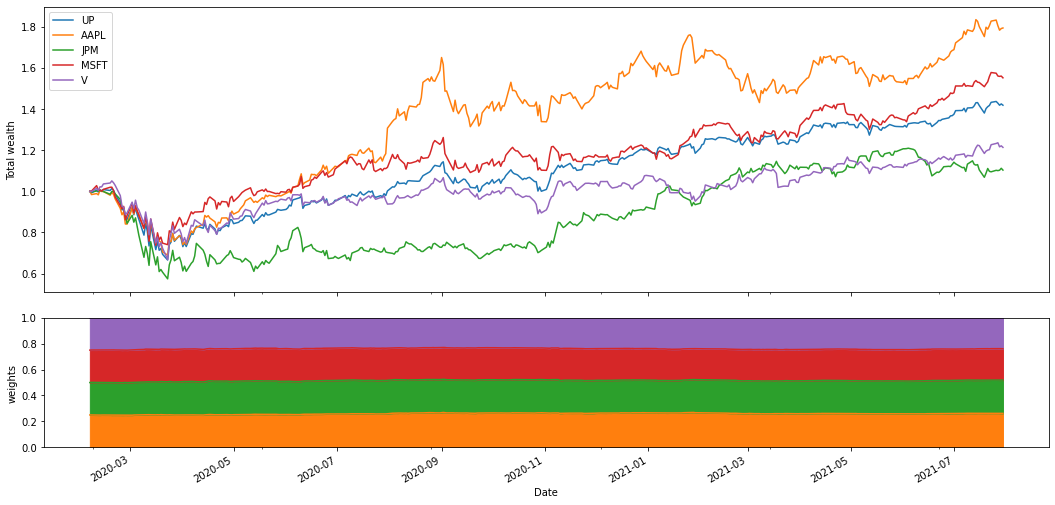

EG Summary:
    Profit factor: 1.15
    Sharpe ratio: 0.85 ± 0.96
    Ulcer index: 3.32
    Information ratio (wrt UCRP): -3.07
    Appraisal ratio (CAPM): -4.27 ± 0.83
    Appraisal ratio (wrt UCRP): -2.39 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.00 / -0.631%
    Annualized return: 29.81%
    Annualized volatility: 34.98%
    Longest drawdown: 114 days
    Max drawdown: 34.33%
    Winning days: 54.5%
    Annual turnover: 2.3
        


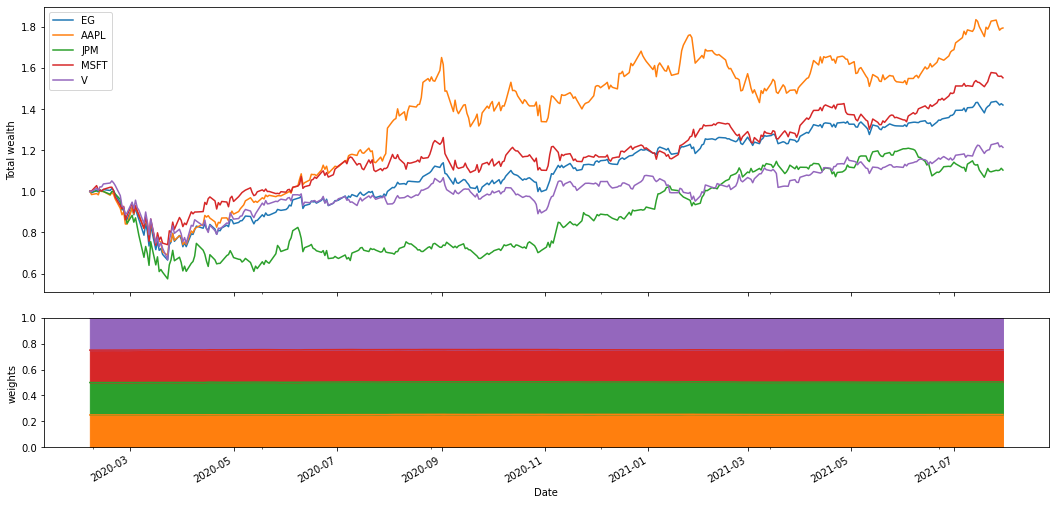

Anticor Summary:
    Profit factor: 1.12
    Sharpe ratio: 0.81 ± 0.95
    Ulcer index: 3.24
    Information ratio (wrt UCRP): 0.02
    Appraisal ratio (CAPM): 0.15 ± 0.83
    Appraisal ratio (wrt UCRP): 0.06 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.99 / 0.925%
    Annualized return: 30.97%
    Annualized volatility: 38.29%
    Longest drawdown: 104 days
    Max drawdown: 34.33%
    Winning days: 52.7%
    Annual turnover: 34.7
        


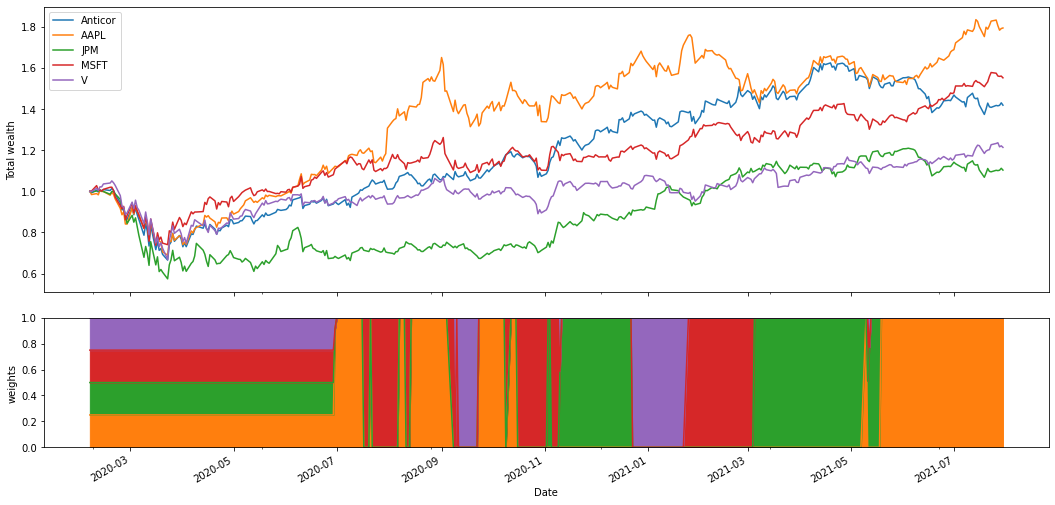

PAMR Summary:
    Profit factor: 0.77
    Sharpe ratio: -1.11 ± 1.05
    Ulcer index: -1.03
    Information ratio (wrt UCRP): -3.69
    Appraisal ratio (CAPM): -3.73 ± 0.83
    Appraisal ratio (wrt UCRP): -3.70 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.02 / -77.354%
    Annualized return: -45.97%
    Annualized volatility: 41.39%
    Longest drawdown: 372 days
    Max drawdown: 55.30%
    Winning days: 44.7%
    Annual turnover: 355.1
        


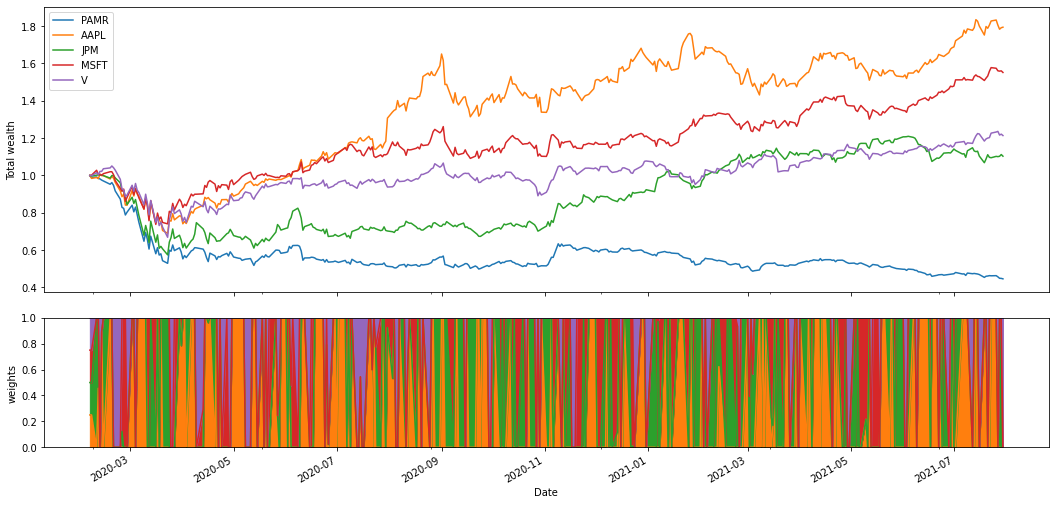

OLMAR Summary:
    Profit factor: 1.05
    Sharpe ratio: 0.48 ± 0.87
    Ulcer index: 1.89
    Information ratio (wrt UCRP): -0.62
    Appraisal ratio (CAPM): -0.56 ± 0.83
    Appraisal ratio (wrt UCRP): -0.65 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.03 / -11.920%
    Annualized return: 19.46%
    Annualized volatility: 40.30%
    Longest drawdown: 111 days
    Max drawdown: 34.33%
    Winning days: 50.8%
    Annual turnover: 56.8
        


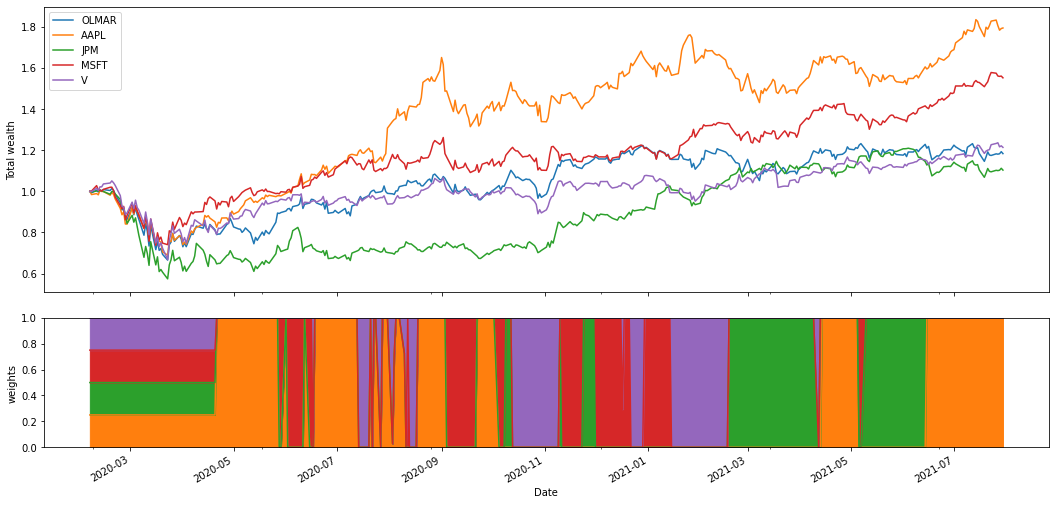

RMR Summary:
    Profit factor: 1.06
    Sharpe ratio: 0.52 ± 0.88
    Ulcer index: 2.01
    Information ratio (wrt UCRP): -0.51
    Appraisal ratio (CAPM): -0.43 ± 0.83
    Appraisal ratio (wrt UCRP): -0.53 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.02 / -9.987%
    Annualized return: 21.11%
    Annualized volatility: 40.23%
    Longest drawdown: 145 days
    Max drawdown: 34.33%
    Winning days: 51.9%
    Annual turnover: 57.3
        


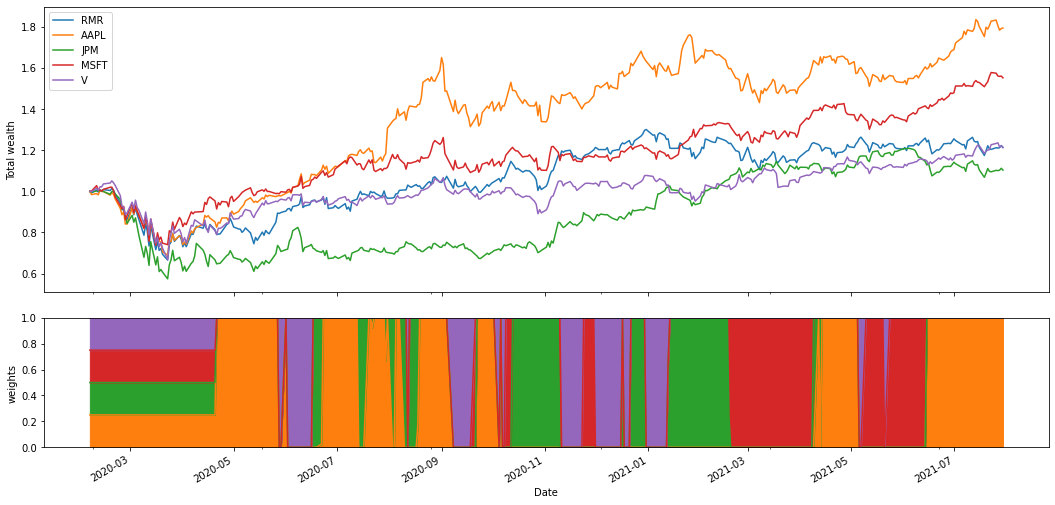

CWMR Summary:
    Profit factor: 0.77
    Sharpe ratio: -1.10 ± 1.04
    Ulcer index: -1.02
    Information ratio (wrt UCRP): -3.67
    Appraisal ratio (CAPM): -3.71 ± 0.83
    Appraisal ratio (wrt UCRP): -3.69 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.03 / -76.987%
    Annualized return: -45.58%
    Annualized volatility: 41.41%
    Longest drawdown: 372 days
    Max drawdown: 55.05%
    Winning days: 44.9%
    Annual turnover: 354.1
        


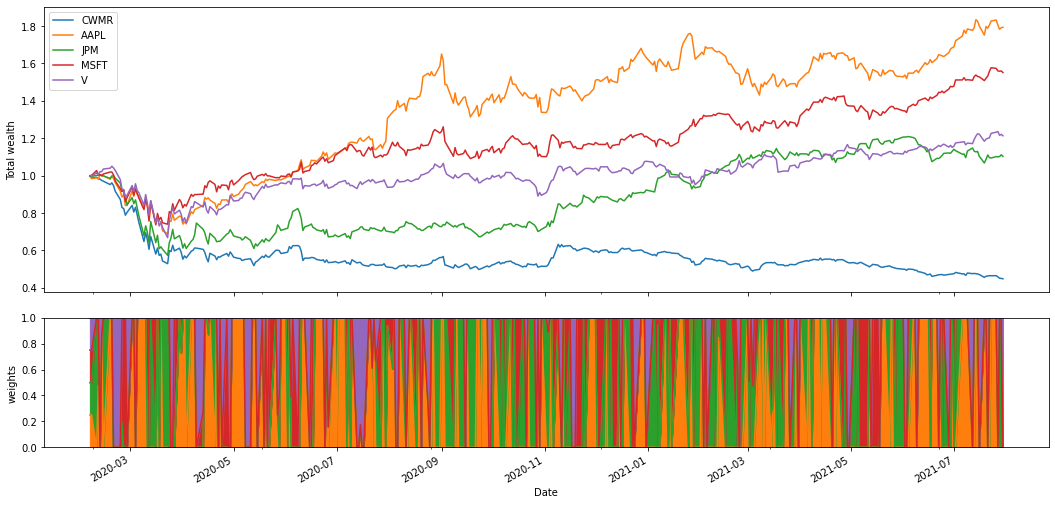

WMAMR Summary:
    Profit factor: 1.01
    Sharpe ratio: 0.29 ± 0.84
    Ulcer index: 0.73
    Information ratio (wrt UCRP): -0.74
    Appraisal ratio (CAPM): -0.79 ± 0.83
    Appraisal ratio (wrt UCRP): -0.96 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.16 / -22.029%
    Annualized return: 13.33%
    Annualized volatility: 46.52%
    Longest drawdown: 258 days
    Max drawdown: 41.12%
    Winning days: 51.3%
    Annual turnover: 78.8
        


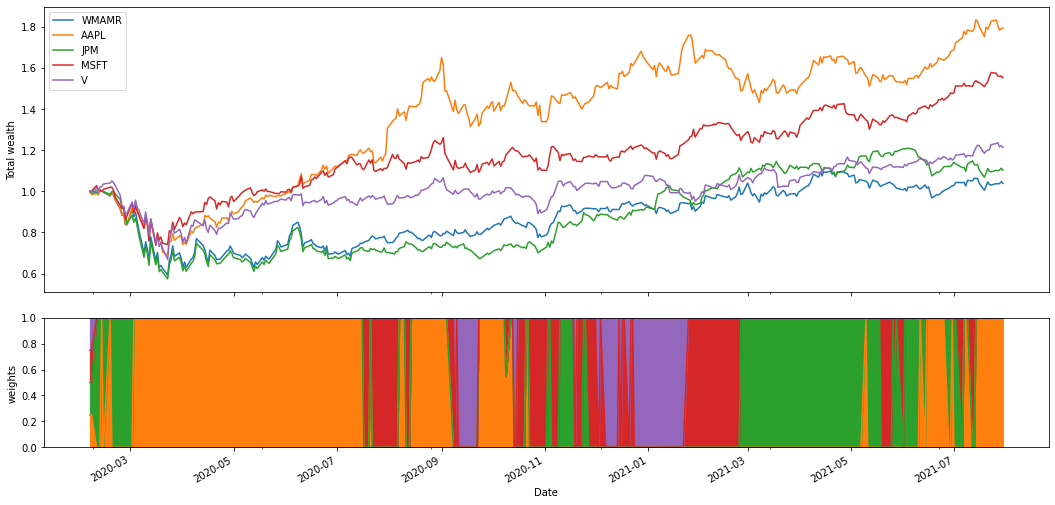

CORN Summary:
    Profit factor: 0.81
    Sharpe ratio: -0.90 ± 0.97
    Ulcer index: -1.21
    Information ratio (wrt UCRP): -3.43
    Appraisal ratio (CAPM): -3.53 ± 0.83
    Appraisal ratio (wrt UCRP): -3.35 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.97 / -64.555%
    Annualized return: -34.97%
    Annualized volatility: 38.82%
    Longest drawdown: 364 days
    Max drawdown: 48.49%
    Winning days: 41.7%
    Annual turnover: 275.4
        


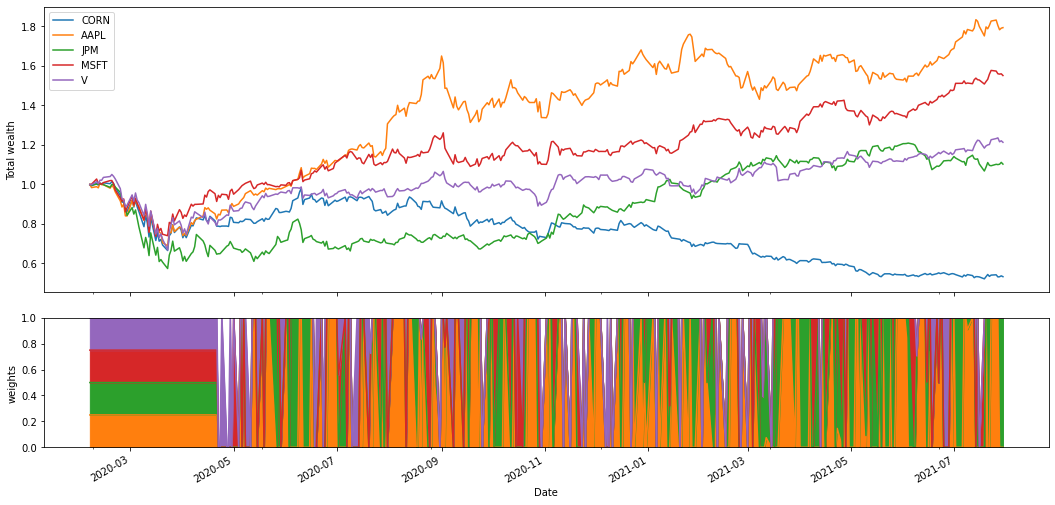

ONS Summary:
    Profit factor: 1.15
    Sharpe ratio: 0.85 ± 0.96
    Ulcer index: 3.37
    Information ratio (wrt UCRP): 0.01
    Appraisal ratio (CAPM): 1.96 ± 0.83
    Appraisal ratio (wrt UCRP): 0.03 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.00 / 0.291%
    Annualized return: 30.72%
    Annualized volatility: 36.25%
    Longest drawdown: 130 days
    Max drawdown: 34.63%
    Winning days: 52.7%
    Annual turnover: 8.8
        


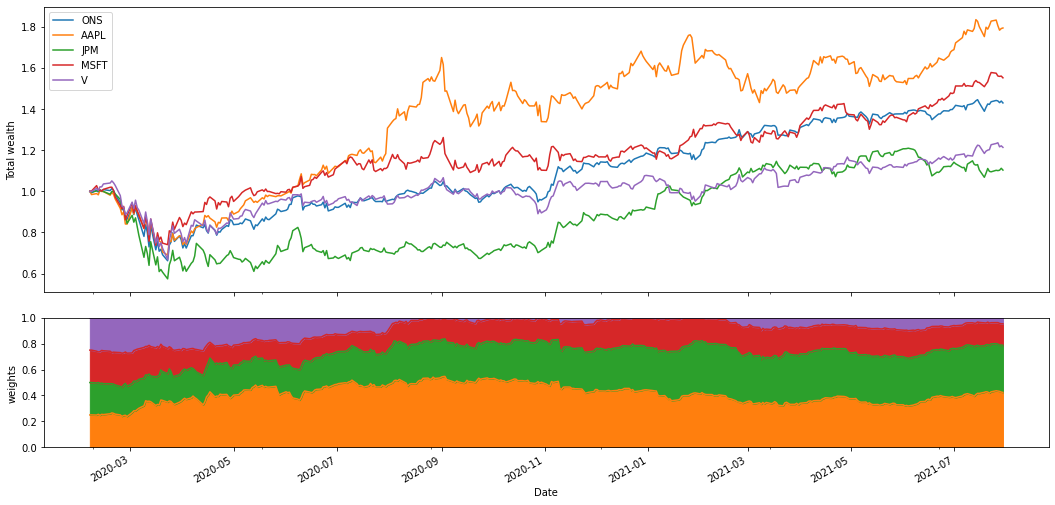

In [45]:
palette = sns.color_palette(n_colors=len(TICKERS)+1)

for i, result in enumerate(results):
    name = results.index[i]
    print(name, result.summary())
    result.plot(assets=True, weights=True, ucrp=False, bah=False, portfolio_label=name, color=palette)
    plt.show()